In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import scipy.signal as sp
import matplotlib.patches as mtp

In [2]:
dir_data=''
time_freq='2'

atl = xr.open_dataset(dir_data+'sla_NorthAtlantic'+time_freq+'D.nc')

In [3]:
def xarray_trend(xarr):    
    from scipy import stats
    # getting shapes
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]

    
    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    intercept = ym - (slope * xm)
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    # misclaneous additional functions
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5
    
    # preparing outputs
    out = xarr[:2].mean('time')

    # 
    xarr_inter = out.copy()
    xarr_inter.name += '_intercept'
    xarr_inter.attrs['units'] = ''
    xarr_inter.values = intercept.reshape(xarr.shape[1:])
    
    # first create variable for slope and adjust meta
    xarr_slope = out.copy()
    xarr_slope.name += '_slope'
    xarr_slope.attrs['units'] = 'units / day'
    xarr_slope.values = slope.reshape(xarr.shape[1:])

    # do the same for the p value
    xarr_p = out.copy()
    xarr_p.name += '_Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])

    # join these variables
    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    xarr_out['intercept'] = xarr_inter
        

    return xarr_out

In [4]:
atl_trend = xarray_trend(atl.sla)

In [5]:
atl_np_Time = atl.sla.time.to_pandas().index.to_julian_date().values
atl_np_Slope = atl_trend.slope.values
atl_np_Inter = atl_trend.intercept.values
atl_np_Trend = atl_np_Slope[...,None] * atl_np_Time + atl_np_Inter[:,:,None]
atl_np_Trend = np.swapaxes(np.swapaxes(atl_np_Trend,0,2),1,2)

atl_dt = atl.sla - atl_np_Trend

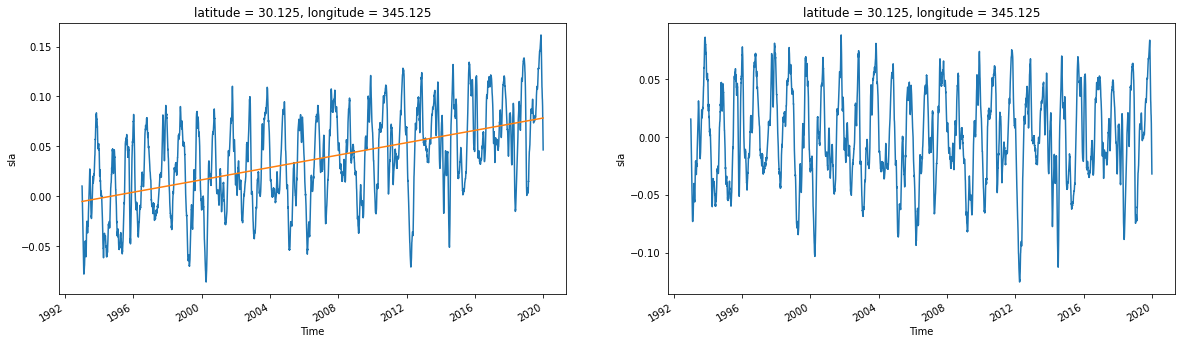

In [6]:
fig, ax = plt.subplots(figsize=(20,5))
plt.subplot(1, 2, 1)
atl.sla.sel(latitude=30, longitude=345, method='nearest').plot()
(atl.sla.sel(latitude=30, longitude=345, method='nearest') - atl_dt.sel(latitude=30, longitude=345, method='nearest')).plot()

plt.subplot(1, 2, 2)
atl_dt.sel(latitude=30, longitude=345, method='nearest').plot()

In [7]:
def rm(x):
    return x - x.mean(dim='time')

atl_dt_month = atl_dt.groupby('time.month').apply(rm)

In [8]:
promedio= np.array([])
for id in range(1,13):
   promedio=np.append(promedio, atl_dt.sel(latitude=30, longitude=345, method='nearest')[atl_dt.sel(latitude=30, longitude=345, method='nearest').time.dt.month==id].mean())

climm =atl_dt.sel(latitude=30, longitude=345, method='nearest').groupby('time.month').mean(dim='time')

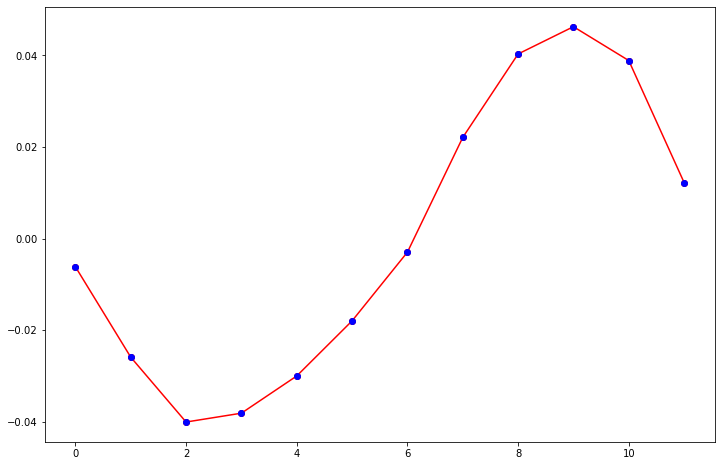

In [9]:
fig , ax = plt.subplots(figsize=(12,8))
ax.plot(promedio,'-ro')
ax.plot(climm,'bo')

/home/pvb/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pvb/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


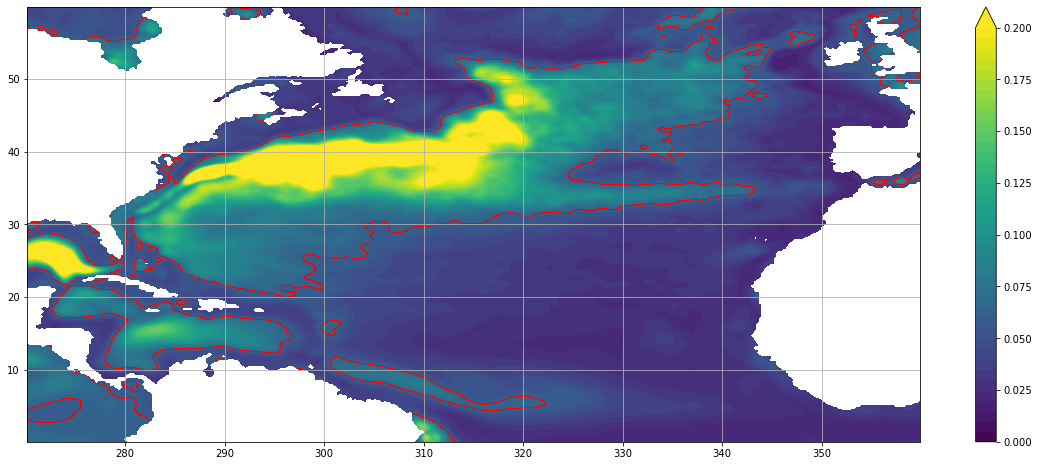

In [10]:
fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0, 0.2, 41)
A = ax.contourf(atl_dt_month.longitude, atl_dt_month.latitude, atl_dt_month.std(dim='time'), 
                levels=levels, extend='max')
fig.colorbar(A)

ax.contourf(atl_dt_month.longitude, atl_dt_month.latitude, atl_dt_month.std(dim='time'), levels=[0.0599, 0.06], colors='red')

ax.xaxis.grid(True, zorder=0)
ax.yaxis.grid(True, zorder=0)

In [11]:
a1_lat = atl_dt_month.latitude.loc[32:37]
a1_lon = atl_dt_month.longitude.loc[325:335]
a1 = atl_dt_month.sel(latitude=a1_lat, longitude=a1_lon)
#a1p = data_dt.sel(latitude=a1_lat, longitude=a1_lon)

a2_lat = atl_dt_month.latitude.loc[32:37]
a2_lon = atl_dt_month.longitude.loc[335:345]
a2 = atl_dt_month.sel(latitude=a2_lat, longitude=a2_lon)
#a2p = data_dt.sel(latitude=a2_lat, longitude=a2_lon)

a3_lat = atl_dt_month.latitude.loc[32:37]
a3_lon = atl_dt_month.longitude.loc[345:352]
a3 = atl_dt_month.sel(latitude=a3_lat, longitude=a3_lon)
#a3p = data_dt.sel(latitude=a3_lat, longitude=a3_lon)

a4_lat = atl_dt_month.latitude.loc[24:29]
a4_lon = atl_dt_month.longitude.loc[340:347]
a4 = atl_dt_month.sel(latitude=a4_lat, longitude=a4_lon)
#a4p = data_dt.sel(latitude=a4_lat, longitude=a4_lon)

a5_lat = atl_dt_month.latitude.loc[28:35]
a5_lon = atl_dt_month.longitude.loc[280:286]
a5 = atl_dt_month.sel(latitude=a5_lat, longitude=a5_lon)
#a5p = data_dt.sel(latitude=a5_lat, longitude=a5_lon)

a6_lat = atl_dt_month.latitude.loc[30:40]
a6_lon = atl_dt_month.longitude.loc[286:295]
a6 = atl_dt_month.sel(latitude=a6_lat, longitude=a6_lon)
#a6p = data_dt.sel(latitude=a6_lat, longitude=a6_lon)

a7_lat = atl_dt_month.latitude.loc[33:43]
a7_lon = atl_dt_month.longitude.loc[295:313]
a7 = atl_dt_month.sel(latitude=a7_lat, longitude=a7_lon)
#a7p = data_dt.sel(latitude=a7_lat, longitude=a7_lon)

a8_lat = atl_dt_month.latitude.loc[33:52]
a8_lon = atl_dt_month.longitude.loc[313:325]
a8 = atl_dt_month.sel(latitude=a8_lat, longitude=a8_lon)
#a8p = data_dt.sel(latitude=a8_lat, longitude=a8_lon)

a9_lat = atl_dt_month.latitude.loc[5:12]
a9_lon = atl_dt_month.longitude.loc[300:315]
a9 = atl_dt_month.sel(latitude=a9_lat, longitude=a9_lon)
#a9p = data_dt.sel(latitude=a9_lat, longitude=a9_lon)

a10_lat = atl_dt_month.latitude.loc[4:9]
a10_lon = atl_dt_month.longitude.loc[315:333]
a10 = atl_dt_month.sel(latitude=a10_lat, longitude=a10_lon)
#a10p = data_dt.sel(latitude=a10_lat, longitude=a10_lon)

/home/pvb/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pvb/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


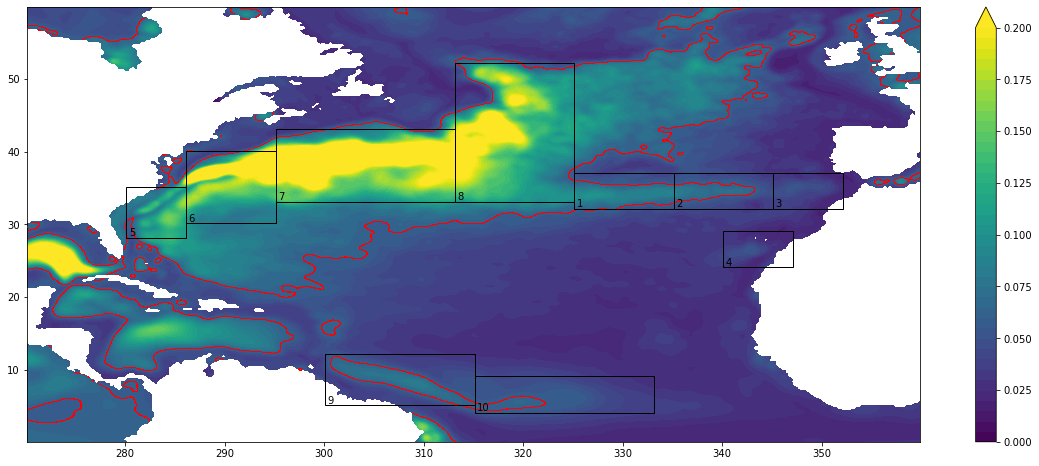

In [12]:
fig, ax = plt.subplots(figsize=(20,8))
levels = np.linspace(0, 0.2, 41)
A = ax.contourf(atl_dt_month.longitude, atl_dt_month.latitude, atl_dt_month.std(dim='time'), 
                levels=levels, extend='max')
fig.colorbar(A)

ax.contourf(atl_dt_month.longitude, atl_dt_month.latitude, atl_dt_month.std(dim='time'), levels=[0.0599, 0.06], colors='red')

ax.add_patch(mtp.Rectangle((a1_lon[0],a1_lat[0]), len(a1_lon)*0.25, len(a1_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a1_lon[1],a1_lat[1], '1')
ax.add_patch(mtp.Rectangle((a2_lon[0],a2_lat[0]), len(a2_lon)*0.25, len(a2_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a2_lon[1],a2_lat[1], '2')
ax.add_patch(mtp.Rectangle((a3_lon[0],a3_lat[0]), len(a3_lon)*0.25, len(a3_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a3_lon[1],a3_lat[1], '3')
ax.add_patch(mtp.Rectangle((a4_lon[0],a4_lat[0]), len(a4_lon)*0.25, len(a4_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a4_lon[1],a4_lat[1], '4')
ax.add_patch(mtp.Rectangle((a5_lon[0],a5_lat[0]), len(a5_lon)*0.25, len(a5_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a5_lon[1],a5_lat[1], '5')
ax.add_patch(mtp.Rectangle((a6_lon[0],a6_lat[0]), len(a6_lon)*0.25, len(a6_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a6_lon[1],a6_lat[1], '6')
ax.add_patch(mtp.Rectangle((a7_lon[0],a7_lat[0]), len(a7_lon)*0.25, len(a7_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a7_lon[1],a7_lat[1], '7')
ax.add_patch(mtp.Rectangle((a8_lon[0],a8_lat[0]), len(a8_lon)*0.25, len(a8_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a8_lon[1],a8_lat[1], '8')
ax.add_patch(mtp.Rectangle((a9_lon[0],a9_lat[0]), len(a9_lon)*0.25, len(a9_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a9_lon[1],a9_lat[1], '9')
ax.add_patch(mtp.Rectangle((a10_lon[0],a10_lat[0]), len(a10_lon)*0.25, len(a10_lat)*0.25, edgecolor = 'black', fill=False))
ax.text(a10_lon[1],a10_lat[1], '10')

plt.show()

In [13]:
def spectrum1(h, dt):
    """
    First cut at spectral estimation: very crude.
    
    Returns frequencies, power spectrum, and
    power spectral density.
    Only positive frequencies between (and not including)
    zero and the Nyquist are output.
    """
    nt = len(h)
    npositive = nt//2
    pslice = slice(1, npositive)
    freqs = np.fft.fftfreq(nt, d=dt)[pslice] 
    ft = np.fft.fft(h, axis=0)[pslice]
    psraw = np.abs(ft) ** 2
    # Double to account for the energy in the negative frequencies.
    psraw *= 2
    # Normalization for Power Spectrum
    psraw /= nt**2
    # Convert PS to Power Spectral Density
    psdraw = psraw * dt * nt  # nt * dt is record length
    return freqs, psraw, psdraw

def spectrum2(h, dt, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weight = np.ones(nsmooth, dtype=float) / nsmooth
    weights = np.ones((nsmooth, 1, 1), dtype=float) / nsmooth
    freqs_s = sp.fftconvolve(freqs, weight, mode='valid')
    
    ps_s = sp.fftconvolve(ps, weights, mode='valid')
    psd_s = sp.fftconvolve(psd, weights, mode='valid')
    
    return freqs_s, ps_s, psd_s
    
def spectrum2p(h, dt, nsmooth=5):
    """
    Add simple boxcar smoothing to the raw periodogram.
    
    Chop off the ends to avoid end effects.
    """
    freqs, ps, psd = spectrum1(h, dt=dt)
    weights = np.ones(nsmooth, dtype=float) / nsmooth
    ps_s = np.convolve(ps, weights, mode='valid')
    psd_s = np.convolve(psd, weights, mode='valid')
    freqs_s = np.convolve(freqs, weights, mode='valid')
    return freqs_s, ps_s, psd_s
        

def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    winp = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    win = np.expand_dims(np.expand_dims(winp, 1), 1)
    return win

def spectrum4(h, dt, nsmooth=5):
    """
    Detrend and apply a quadratic window.
    """
    n = len(h)

    #h_detrended = detrend(h)
    
    winweights = quadwin(n)
    #h_win = h_detrended * winweights
    h_win = h * winweights
    
    freqs, ps, psd = spectrum2(h_win, dt=dt, nsmooth=nsmooth)
    
    # Compensate for the energy suppressed by the window.
    psd *= n / (winweights**2).sum()
    ps *= n**2 / winweights.sum()**2
    
    return freqs, ps, psd

In [14]:
freqs1, ps1, psd1 = spectrum4(a1.values, dt=int(time_freq))
freqs2, ps2, psd2 = spectrum4(a2.values, dt=int(time_freq))
freqs3, ps3, psd3 = spectrum4(a3.values, dt=int(time_freq))
freqs4, ps4, psd4 = spectrum4(a4.values, dt=int(time_freq))
freqs5, ps5, psd5 = spectrum4(a5.values, dt=int(time_freq))
freqs6, ps6, psd6 = spectrum4(a6.values, dt=int(time_freq))
freqs7, ps7, psd7 = spectrum4(a7.values, dt=int(time_freq))
freqs8, ps8, psd8 = spectrum4(a8.values, dt=int(time_freq))
freqs9, ps9, psd9 = spectrum4(a9.values, dt=int(time_freq))
freqs10, ps10, psd10 = spectrum4(a10.values, dt=int(time_freq))

In [15]:
media1 = np.mean(np.mean(psd1, axis=1), axis=1)
media2 = np.mean(np.mean(psd2, axis=1), axis=1)
media3 = np.nanmean(np.nanmean(psd3, axis=1), axis=1)
media4 = np.nanmean(np.nanmean(psd4, axis=1), axis=1)
media5 = np.nanmean(np.nanmean(psd5, axis=1), axis=1)
media6 = np.mean(np.mean(psd6, axis=1), axis=1)
media7 = np.mean(np.mean(psd7, axis=1), axis=1)
media8 = np.mean(np.mean(psd8, axis=1), axis=1)
media9 = np.nanmean(np.nanmean(psd9, axis=1), axis=1)
media10 = np.mean(np.mean(psd10, axis=1), axis=1)

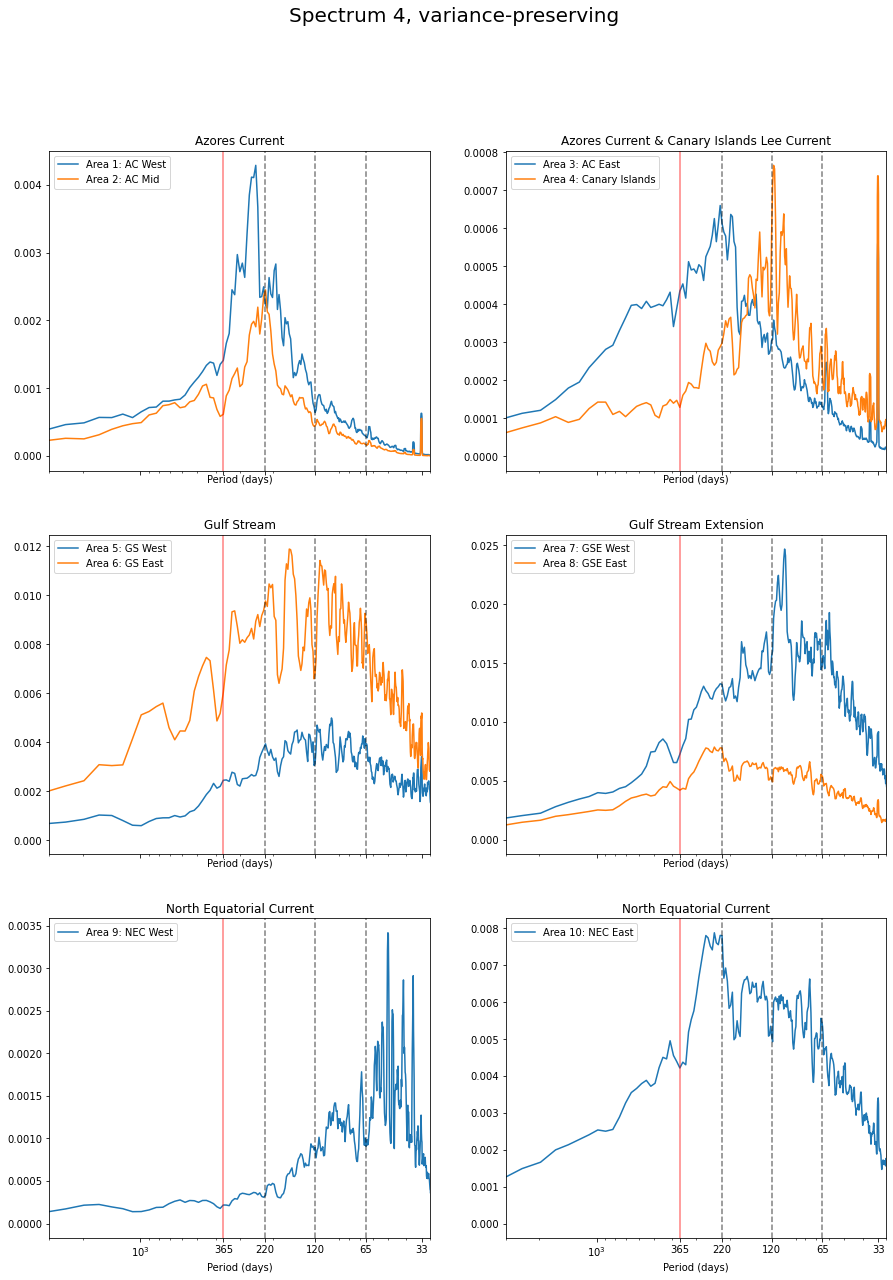

In [20]:
fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(3000, 30)
fig.suptitle('Spectrum 4, variance-preserving', fontsize=20)

ax[0, 0].set_title('Azores Current')
ax[0, 0].semilogx((1/freqs1)[::-1], media1[::-1]*freqs1[::-1])
ax[0, 0].semilogx((1/freqs2)[::-1], media2[::-1]*freqs2[::-1])

ax[0, 1].set_title('Azores Current & Canary Islands Lee Current')
ax[0, 1].semilogx((1/freqs3)[::-1], media3[::-1]*freqs3[::-1])
ax[0, 1].semilogx((1/freqs4)[::-1], media4[::-1]*freqs4[::-1])

ax[1, 0].set_title('Gulf Stream')
ax[1, 0].semilogx((1/freqs5)[::-1], media5[::-1]*freqs5[::-1])
ax[1, 0].semilogx((1/freqs6)[::-1], media6[::-1]*freqs6[::-1])

ax[1, 1].set_title('Gulf Stream Extension')
ax[1, 1].semilogx((1/freqs7)[::-1], media7[::-1]*freqs7[::-1])
ax[1, 1].semilogx((1/freqs8)[::-1], media8[::-1]*freqs8[::-1])

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].semilogx((1/freqs9)[::-1], media9[::-1]*freqs9[::-1])

ax[2, 1].set_title('North Equatorial Current')
ax[2, 1].semilogx((1/freqs10)[::-1], media8[::-1]*freqs10[::-1])

ax[0, 0].legend(('Area 1: AC West', 'Area 2: AC Mid'))
ax[0, 1].legend(('Area 3: AC East', 'Area 4: Canary Islands'))
ax[1, 0].legend(('Area 5: GS West', 'Area 6: GS East'))
ax[1, 1].legend(('Area 7: GSE West', 'Area 8: GSE East'))
ax[2, 0].legend(('Area 9: NEC West', ))
ax[2, 1].legend(('Area 10: NEC East', ))

for ax in ax.flat:
    ax.axvline(365, ls='-', color='r', alpha=0.5)
    ax.axvline(220, ls='--', color='k', alpha=0.5)
    ax.axvline(120, ls='--', color='k', alpha=0.5)
    ax.axvline(65, ls='--', color='k', alpha=0.5)
    ax.set(xlabel='Period (days)')
    

plt.xticks([33, 65, 120, 220, 365, 1000], ['33', '65', '120', '220', '365', '$10^3$'])
fig.savefig("Spectrum4_VP.png")  


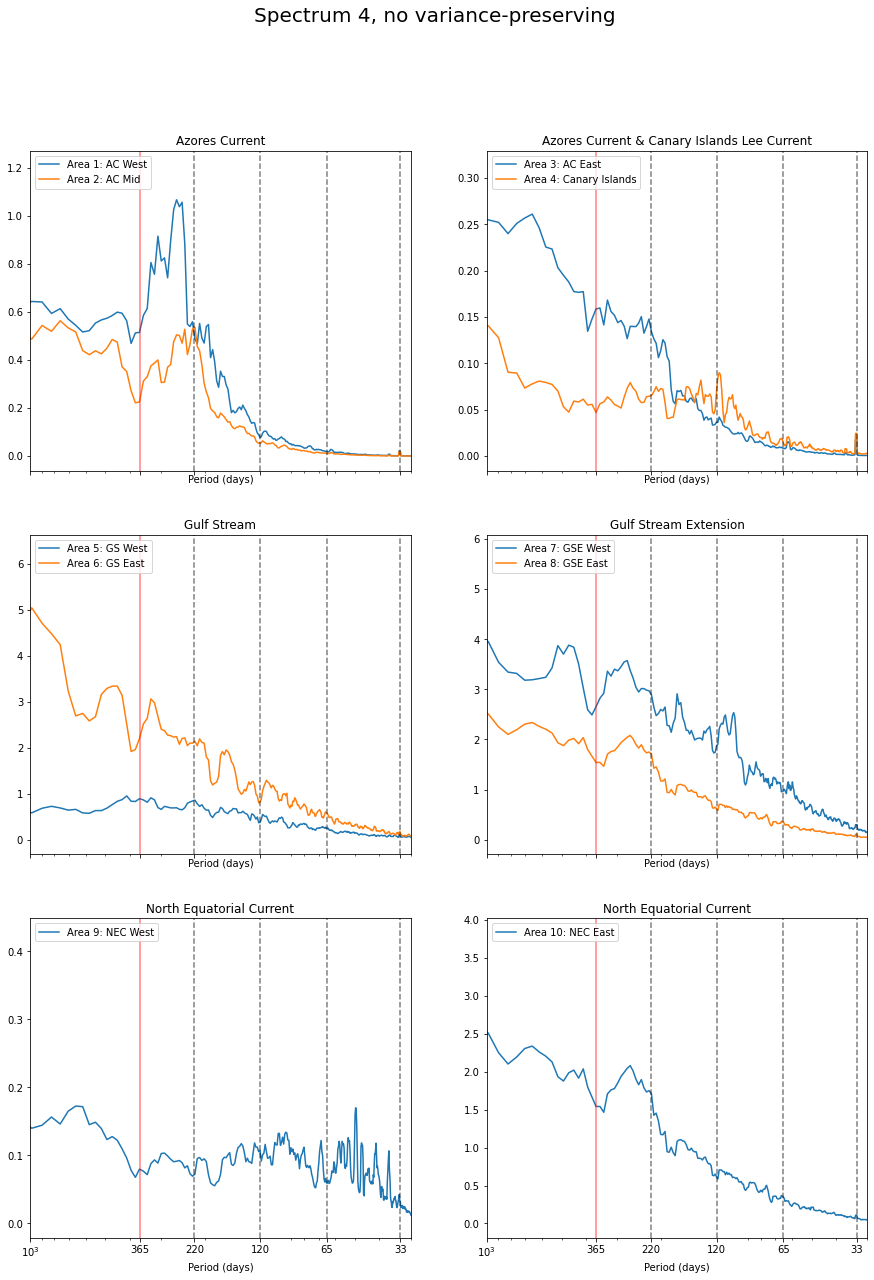

In [19]:
fig, ax = plt.subplots(3,2 , figsize=(15,20), sharex=True)
plt.xlim(1000, 30)
fig.suptitle('Spectrum 4, no variance-preserving', fontsize=20)


ax[0, 0].set_title('Azores Current')
ax[0, 0].semilogx((1/freqs1)[::-1], media1[::-1])
ax[0, 0].semilogx((1/freqs2)[::-1], media2[::-1])

ax[0, 1].set_title('Azores Current & Canary Islands Lee Current')
ax[0, 1].semilogx((1/freqs3)[::-1], media3[::-1])
ax[0, 1].semilogx((1/freqs4)[::-1], media4[::-1])

ax[1, 0].set_title('Gulf Stream')
ax[1, 0].semilogx((1/freqs5)[::-1], media5[::-1])
ax[1, 0].semilogx((1/freqs6)[::-1], media6[::-1])

ax[1, 1].set_title('Gulf Stream Extension')
ax[1, 1].semilogx((1/freqs7)[::-1], media7[::-1])
ax[1, 1].semilogx((1/freqs8)[::-1], media8[::-1])

ax[2, 0].set_title('North Equatorial Current')
ax[2, 0].semilogx((1/freqs9)[::-1], media9[::-1])

ax[2, 1].set_title('North Equatorial Current')
ax[2, 1].semilogx((1/freqs10)[::-1], media8[::-1])

ax[0, 0].legend(('Area 1: AC West', 'Area 2: AC Mid'))
ax[0, 1].legend(('Area 3: AC East', 'Area 4: Canary Islands'))
ax[1, 0].legend(('Area 5: GS West', 'Area 6: GS East'))
ax[1, 1].legend(('Area 7: GSE West', 'Area 8: GSE East'))
ax[2, 0].legend(('Area 9: NEC West', ))
ax[2, 1].legend(('Area 10: NEC East', ))


for ax in ax.flat:
    ax.axvline(365, ls='-', color='r', alpha=0.5)
    ax.axvline(220, ls='--', color='k', alpha=0.5)
    ax.axvline(120, ls='--', color='k', alpha=0.5)
    ax.axvline(65, ls='--', color='k', alpha=0.5)
    ax.axvline(33, ls='--', color='k', alpha=0.5)
    ax.set(xlabel='Period (days)')

plt.xticks([33, 65, 120, 220, 365, 1000], ['33', '65', '120', '220', '365', '$10^3$'])
plt.show()

fig.savefig("Spectrum4.png")    